In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
from os.path import splitext
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [2]:
train_images = glob("../data/train/*.jpg")
test_images = glob("../data/test/*.jpg")

In [3]:
def get_set(d):
    s = []
    for im in d:
        arr = np.asarray(Image.open(im))
        arr = arr / np.max(arr)
        arr *= 2
        arr -= 1
        arr = torch.tensor(arr)
        f_name = splitext(im)[0] + ".txt"
        f = open(f_name, "r")
        c = int(f.read())
        f.close()
        s.append([arr, c])
    return np.array(s, dtype='object')

In [4]:
trainset = get_set(train_images)
testset = get_set(test_images)

In [5]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 24, 5)
        """self.conv4 = nn.Conv2d(24, 36, 5)
        self.conv5 = nn.Conv2d(36, 48, 5)"""
        i_s = 18816
        self.fc1 = nn.Linear(i_s , i_s //2)
        self.fc7 = nn.Linear(i_s //2 , i_s // 8)
        self.fc2 = nn.Linear(i_s // 8, 864)
        self.fc4 = nn.Linear(864, 120)
        
        self.fc5 = nn.Linear(120, 84)
        self.fc6 = nn.Linear(84, 1)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        # x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        # x = F.relu(self.conv5(x))
        
        x = torch.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        return x

In [67]:
def init_random_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.normal_(m.weight, mean=2, std=2)
    elif isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, mean=2, std=1)

In [68]:
net = Net()
net = net.double()

In [69]:
net.forward((testset[0][0].unsqueeze(0).unsqueeze(0)))

tensor([0.], dtype=torch.float64, grad_fn=<ReluBackward0>)

In [70]:
res = 0
while res <= 0 or res > 10:
    net = net.apply(init_random_weights)
    res = net.forward((testset[0][0].unsqueeze(0).unsqueeze(0))).item()

KeyboardInterrupt: 

In [ ]:
res

In [80]:
net = net.apply(init_random_weights)

In [81]:
net.forward((testset[0][0].unsqueeze(0).unsqueeze(0)))

tensor([9.5229e+25], dtype=torch.float64, grad_fn=<ReluBackward0>)

In [104]:
loss_func = nn.MSELoss()
lr = 1e-3# 1e-6
opt=torch.optim.Adam(net.parameters(),lr)
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=18816, out_features=9408, bias=True)
  (fc7): Linear(in_features=9408, out_features=2352, bias=True)
  (fc2): Linear(in_features=2352, out_features=864, bias=True)
  (fc4): Linear(in_features=864, out_features=120, bias=True)
  (fc5): Linear(in_features=120, out_features=84, bias=True)
  (fc6): Linear(in_features=84, out_features=1, bias=True)
)


In [91]:
def train_step(inp, target):
    net.zero_grad()
    output = net(inp)
    target = torch.tensor(target).view(-1,1).double()
    loss = loss_func(output, target)
    loss.backward()
    opt.step()
    return loss

In [97]:
def do_epoch(trainset, pbar):
    cumulative_loss = 0
    np.random.shuffle(trainset)
    for i in range(trainset.shape[0]):
        x = trainset[i][0]
        y = trainset[i][1]
        loss = train_step(x.unsqueeze(0).unsqueeze(0), y)
        cumulative_loss += loss.item()
        if i % 10 == 9:
            pbar.update(10)
        # if i % 10 == 0:
        #    print(loss)
    pbar.update(trainset.shape[0] % 10)
    return cumulative_loss

In [98]:
def train(trainset, num_epochs=1_000):
    losses = []
    pbar = tqdm(total=num_epochs * trainset.shape[0])
    for i in range(num_epochs):
        pbar.set_description("Epoch {}".format(i+1))
        # print("Epoch {}/{}".format(i+1, num_epochs))
        losses.append(do_epoch(trainset, pbar))
        if i % 25 == 0:
            torch.save(net, "checkpoints/{}.mdl".format(i))
            print("Checkpoint saved at {}, loss={}".format(i+1, losses[-1]))
    return losses

In [106]:
l = train(trainset)
# LOWER TRAINING RATE AFTER

Checkpoint saved at 1, loss=1.6876389126641712e+49
Checkpoint saved at 26, loss=1.8658175150328974e+48
Checkpoint saved at 51, loss=5.605105123327654e+47
Checkpoint saved at 76, loss=2.2056047644194993e+47
Checkpoint saved at 101, loss=9.278475689436224e+46
Checkpoint saved at 126, loss=3.824175472785208e+46
Checkpoint saved at 151, loss=1.3815261944311615e+46
Checkpoint saved at 176, loss=4.062667851398939e+45
Checkpoint saved at 201, loss=9.193530180352788e+44
Checkpoint saved at 226, loss=1.3625202288023992e+44
Checkpoint saved at 251, loss=1.276242114683837e+43


KeyboardInterrupt: 

In [ ]:
plt.plot(l)

In [105]:
net(testset[0][0].unsqueeze(0).unsqueeze(0))

tensor([2.4607e+23], dtype=torch.float64, grad_fn=<ReluBackward0>)

In [22]:
test_images

['../data/test/41_2011.jpg',
 '../data/test/44_2008.jpg',
 '../data/test/46_2014.jpg',
 '../data/test/42_2008.jpg',
 '../data/test/47_2008.jpg',
 '../data/test/49_2013.jpg',
 '../data/test/43_2011.jpg',
 '../data/test/48_2011.jpg',
 '../data/test/45_2011.jpg',
 '../data/test/40_2008.jpg']

In [25]:
for e in testset:
    print(net(e[0].unsqueeze(0).unsqueeze(0)))

tensor([0.], dtype=torch.float64, grad_fn=<ReluBackward0>)
tensor([0.], dtype=torch.float64, grad_fn=<ReluBackward0>)
tensor([0.], dtype=torch.float64, grad_fn=<ReluBackward0>)
tensor([0.], dtype=torch.float64, grad_fn=<ReluBackward0>)
tensor([0.], dtype=torch.float64, grad_fn=<ReluBackward0>)
tensor([0.], dtype=torch.float64, grad_fn=<ReluBackward0>)
tensor([0.], dtype=torch.float64, grad_fn=<ReluBackward0>)
tensor([0.], dtype=torch.float64, grad_fn=<ReluBackward0>)
tensor([0.], dtype=torch.float64, grad_fn=<ReluBackward0>)
tensor([0.], dtype=torch.float64, grad_fn=<ReluBackward0>)


In [138]:
testset

array([[tensor([[-0.1608, -0.1686, -0.1451,  ..., -0.0902, -0.0510, -0.0431],
        [-0.1608, -0.1608, -0.1451,  ..., -0.0510, -0.0039,  0.0275],
        [-0.1843, -0.1686, -0.1529,  ..., -0.0196,  0.0275,  0.0510],
        ...,
        [-0.2000, -0.1765, -0.1608,  ...,  0.0745,  0.0824,  0.0667],
        [-0.1843, -0.1765, -0.1765,  ...,  0.0275,  0.0196,  0.0039],
        [-0.1608, -0.1765, -0.2000,  ..., -0.0275, -0.0431, -0.0667]],
       dtype=torch.float64),
        3],
       [tensor([[-0.5216, -0.4824, -0.3333,  ..., -0.1137, -0.0196, -0.1529],
        [-0.4588, -0.4353, -0.3098,  ..., -0.0275,  0.0980,  0.0353],
        [-0.5137, -0.5216, -0.4353,  ...,  0.0980,  0.1373,  0.0588],
        ...,
        [-0.3020, -0.2392, -0.1922,  ..., -0.3804, -0.3490, -0.3882],
        [-0.2784, -0.0980, -0.0118,  ..., -0.3961, -0.3569, -0.3255],
        [-0.2000, -0.0902, -0.0667,  ..., -0.4039, -0.3490, -0.2235]],
       dtype=torch.float64),
        12],
       [tensor([[-0.2627, -0.4745

In [109]:
from sklearn import mixture

In [111]:
from sklearn import mixture

In [144]:
g = mixture.GaussianMixture(n_components=3)

In [241]:
x = trainset[1][0].reshape(-1, 1)

In [242]:
g.fit(x)

GaussianMixture(n_components=3)

In [243]:
m = g.predict(x)

In [244]:
m = m.reshape(256,256)

In [245]:
np.unique(m)

array([0, 1, 2])

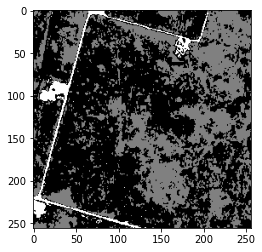

In [246]:
plt.imshow(m, cmap='gray')

In [250]:
max_pixels = np.where(m == 2)

In [251]:
max_pixels = np.array(max_pixels)

In [252]:
max_pixels

array([[  0,   0,   0, ..., 255, 255, 255],
       [ 65,  66,  67, ..., 126, 131, 132]])

In [253]:
max_pixels = max_pixels.T

In [254]:
from sklearn.cluster import DBSCAN

In [255]:
c = DBSCAN(eps=1, min_samples=5)

In [256]:
res = c.fit_predict(max_pixels)

In [257]:
output_im = np.zeros((256,256))
for p, l in zip(max_pixels, res):
    output_im[p[0], p[1]] = l

In [258]:
import collections

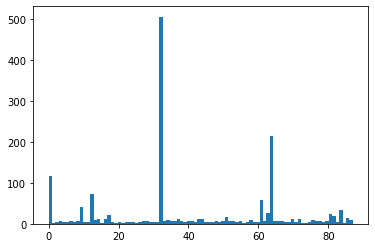

In [260]:
res_tmp = res[res != -1]

plt.hist(res_tmp, bins=len(np.unique(res_tmp)))
plt.show()

In [261]:
c = collections.Counter(res_tmp)

In [262]:
output = {}
for e in c:
    if c[e] > 100:
        output[e] = c[e]

In [263]:
for i in output_im[0]:
    if i not in output:
        i = 0

In [264]:
print(output)

{0: 116, 32: 506, 64: 214}


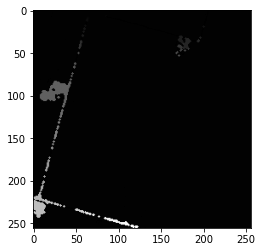

In [265]:
plt.imshow(output_im, cmap='gray')

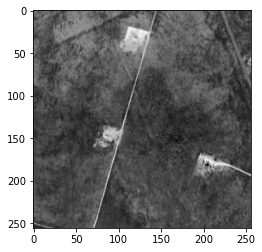

In [188]:
plt.imshow(trainset[0][0], cmap='gray')